In [1]:
# This script is based on:
# https://www.tensorflow.org/get_started/mnist/pros

import sys
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.framework import graph_util as gu
from tensorflow.python.framework.graph_util import remove_training_nodes
from tensorflow.tools.graph_transforms import TransformGraph
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt

/Users/yuezha01/anaconda3/envs/tensorflow_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/yuezha01/anaconda3/envs/tensorflow_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
# Load the test data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [102]:
tf.keras.preprocessing.image

<module 'tensorflow.keras.preprocessing.image' from '/Users/yuezha01/anaconda3/envs/tensorflow_cpu/lib/python3.6/site-packages/tensorflow/keras/preprocessing/image/__init__.py'>

In [104]:
# CREATE MORE IMAGES VIA DATA AUGMENTATION
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

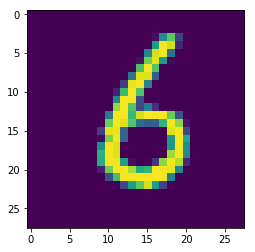

In [109]:
plt.imshow(mnist.train.images[9,].reshape(28, 28))
plt.show()

In [112]:
image_tmp, label_tmp = datagen.flow(mnist.train.images[9,].reshape(1, 28, 28, 1), 
                                    mnist.train.labels[9,].reshape(1, 10)).next()

In [116]:
image_tmp.shape

(1, 28, 28, 1)

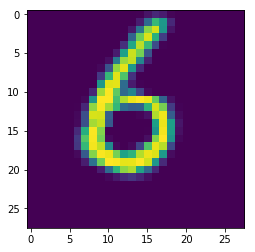

In [117]:
plt.imshow(image_tmp.reshape(28, 28))
plt.show()

### TF model

In [202]:
tf.reset_default_graph()

In [203]:
img_size, num_channels, num_classes = 28, 1, 10
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')
y_ = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_')

In [204]:
def weight_variable(shape, stddev, wd):
    var = tf.Variable(tf.truncated_normal(shape, stddev=stddev))
    if wd is not None:
        weight_decay = tf.multiply(tf.nn.l2_loss(var), wd, name='weight_loss')
        tf.add_to_collection('losses', weight_decay)
    return var

def bias_variable(shape, val):
    initial = tf.constant(val, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [205]:
W_conv1 = weight_variable([5, 5, 1, 32], stddev=0.1, wd=None)
b_conv1 = bias_variable([32], 0.1)
conv1 = tf.nn.conv2d(x, W_conv1, [1, 1, 1, 1], padding='SAME', name="conv1")
h_conv1 = tf.nn.relu(tf.add(conv1, b_conv1), name="h_conv1")
h_pool1 = max_pool_2x2(h_conv1)
drop1 = tf.nn.dropout(h_pool1, keep_prob=1.0)

In [206]:
W_conv2 = weight_variable([5, 5, 32, 32], stddev=0.1, wd=None)
b_conv2 = bias_variable([32], 0.1)
conv2 = tf.nn.conv2d(drop1, W_conv2, [1, 1, 1, 1], padding='SAME', name="conv2")
h_conv2 = tf.nn.relu(tf.add(conv2, b_conv2), name="h_conv2")
h_pool2 = max_pool_2x2(h_conv2)
drop2 = tf.nn.dropout(h_pool2, keep_prob=1.0)

In [207]:
W_conv3 = weight_variable([5, 5, 32, 32], stddev=0.1, wd=None)
b_conv3 = bias_variable([32], 0.1)
conv3 = tf.nn.conv2d(drop2, W_conv3, [1, 1, 1, 1], padding='SAME', name="conv3")
h_conv3 = tf.nn.relu(tf.add(conv3, b_conv3), name="h_conv3")
h_pool3 = max_pool_2x2(h_conv3)
#drop3 = tf.nn.dropout(h_pool3, keep_prob=0.8)

In [208]:
h_pool3_flat = tf.reshape(h_pool3, [-1, 4 * 4 * 32])

In [209]:
W_fc1 = weight_variable([4 * 4 * 32, 128], stddev=0.1, wd=None)
b_fc1 = bias_variable([128], 0.1)
h_fc1 = tf.nn.relu(tf.add(tf.matmul(h_pool3_flat, W_fc1), b_fc1), name="fc1")
drop4 = tf.nn.dropout(h_fc1, keep_prob=1.0)

W_fc2 = weight_variable([128, 10], stddev=0.1, wd=None)
b_fc2 = bias_variable([10], 0.1)
logits = tf.add(tf.matmul(drop4, W_fc2), b_fc2, name="logits")
y_pred = tf.argmax(logits, axis=1, name="y_pred")

In [210]:
with tf.name_scope("Loss"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, 
                                                               logits=logits)
    loss = tf.reduce_mean(cross_entropy, name="cross_entropy_loss")
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss, name="train_step")
  
# Here we specify the output as "Prediction/y_pred", this will be important later
with tf.name_scope("Prediction"): 
    correct_prediction = tf.equal(y_pred, 
                                  tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name="accuracy")

In [213]:
batch_size = 100
n_epochs = 50
n_batches = int(mnist.train.num_examples / batch_size)
print(n_batches)

550


In [212]:
sess = tf.Session()
# Initialize the variables (i.e. assign their default value)
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

train_loss, train_accuracy = sess.run([loss, accuracy], 
                                      feed_dict={x: mnist.train.images.reshape(mnist.train.num_examples, img_size, img_size, num_channels), 
                                                 y_: mnist.train.labels})
print('Epoch %d, training loss: %g, training accuracy: %g' % (0, train_loss, train_accuracy))
val_loss, val_accuracy = sess.run([loss, accuracy], 
                                  feed_dict={x: mnist.validation.images.reshape(mnist.validation.num_examples, img_size, img_size, num_channels),
                                             y_: mnist.validation.labels})
print('Epoch %d, validation loss: %g, validation accuracy %g' % (0, val_loss, val_accuracy))

Epoch 0, training loss: 4.22769, training accuracy: 0.0989818
Epoch 0, validation loss: 4.26632, validation accuracy 0.0958


In [ ]:
for i in range(n_epochs):
    for j in range(n_batches):
        batch_images, batch_labels = mnist.train.next_batch(batch_size)
        sess.run(train_step, feed_dict={x: batch_images.reshape(batch_size, img_size, img_size, num_channels), 
                                        y_: batch_labels})
        
    if i % 10 == 0:
        train_loss, train_accuracy = sess.run([loss, accuracy], 
                                              feed_dict={x: mnist.train.images.reshape(mnist.train.num_examples, img_size, img_size, num_channels), 
                                                         y_: mnist.train.labels})
        print('Epoch %d, training loss: %g, training accuracy: %g' % (i, train_loss, train_accuracy))
        val_loss, val_accuracy = sess.run([loss, accuracy], 
                                          feed_dict={x: mnist.validation.images.reshape(mnist.validation.num_examples, img_size, img_size, num_channels),
                                                     y_: mnist.validation.labels})
        print('Epoch %d, validation loss: %g, validation accuracy %g' % (i, val_loss, val_accuracy))

In [173]:
print('test accuracy %g' % sess.run(accuracy, 
                                    feed_dict={x: mnist.validation.images.reshape(mnist.validation.num_examples, img_size, img_size, num_channels), 
                                               y_: mnist.validation.labels}))

test accuracy 0.9898


In [174]:
print('test accuracy %g' % sess.run(accuracy, 
                                    feed_dict={x: mnist.test.images.reshape(mnist.test.num_examples, img_size, img_size, num_channels), 
                                               y_: mnist.test.labels}))

test accuracy 0.9914


In [175]:
saver.save(sess, "./chkps/mnist_cnn_small_dropout08_lr04")
out_nodes = [y_pred.op.name]
print(out_nodes)

['y_pred']


In [176]:
sub_graph_def = remove_training_nodes(sess.graph_def)

In [177]:
sub_graph_def = gu.convert_variables_to_constants(sess, sub_graph_def, out_nodes)

INFO:tensorflow:Froze 10 variables.
INFO:tensorflow:Converted 10 variables to const ops.


In [178]:
graph_path = tf.train.write_graph(sub_graph_def,
                                  "./mnist_cnn_small_dropout08_lr04",
                                  "mnist_cnn.pb",
                                  as_text=False)

print('written graph to: %s' % graph_path)

written graph to: ./mnist_cnn_small_dropout08_lr04/mnist_cnn.pb


In [179]:
sess.run(y_pred, feed_dict={x: mnist.test.images[[3, 2, 1, 18, 4, 15, 11, 0, 61, 7], :].reshape(10, 28, 28, 1)})

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [180]:
sess.close()